# Analysis for writing paper 

Author: Sahar H. El Abbadi
Start date: Sept 20, 2024

Purpose: calculations for Baseline Paper 

Input files: 
- tt_output_20240926.csv - from Abby's version of Jianan's code
- wwtp_output_20240926.csv - from Abby's version of Jianan's code
- tt_assignment_2022_new_nc.csv - from Abby's treatment train assignment code

In [1]:
# Set up 

######## Import modules ########
import pandas as pd
import pathlib
import ast # for converting text in TT column to a python list 

# unit conversions
from baseline_utilities.baseline_utilities import mgd_to_Bm3_yr, kg_per_day_to_mmt_per_year

# treatment train manipulation functions 
from baseline_utilities.baseline_utilities import combine_liquid_treatment, combine_solids_treatment, combine_primary, combine_treatment_target, process_treatment_data, calc_key_stats, concat_labels, calculate_facility_fraction_for_process, filter_facilities_by_process

######## Data prep ########

### Treatment train data 
# Load treatment train summary data
tt_data = pd.read_csv(pathlib.PurePath('01_raw_data', 'baseline_paper', 'tt_output_20240927.csv')) # main data file

# Add column with flow in Bm3/year
tt_data['flow_Bm3yr'] = tt_data['TT_flow_MGD'].apply(mgd_to_Bm3_yr)
tt_data = tt_data.rename(columns={'TT_flow_MGD':'flow_mgd', 'TT_number':'count'})

### Facility level data 
# Load facility level results
facility_data = pd.read_csv(pathlib.PurePath('01_raw_data', 'baseline_paper', 'wwtp_output_20240927.csv'))

# Convert 'TT' columnn from a string to a python list of strings
def convert_to_list(value):
    try:
        # Convert only if the value is a string and starts/ends with brackets
        if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
            return ast.literal_eval(value)  # Safe conversion to a list
        return value  # Return as-is if not a list-like string
    except (ValueError, SyntaxError):
        return value  # If there's an error, return the value as is

# Apply conversion to the 'TT' column
facility_data['TT'] = facility_data['TT'].apply(convert_to_list)

# Determine total number of treatment trains per facility
facility_data['TT_count'] = facility_data['TT'].apply(len)

# Calculate flow per treatment train 
facility_data['TT_flow_mgd'] = facility_data['FLOW_2022_MGD_FINAL'] / facility_data['TT_count']

# Set total number of facilities
total_facilities = len(facility_data)

# Number of treatment trains
total_trains = len(tt_data)

# Paper analysis 

Data analysis for paper.

Manuscript version: 20240917_AMO_Task3_Inventory_Paper_Draft_SE

## Number and throughput of US WWTPs by treatment train type 

First section of the Main text 

### Liquids treatment train 

In [2]:
### What is the most common liquids treatment train? 
liquids_sorted_by_count = process_treatment_data(tt_data, combine_liquid_treatment, 'tt_liquids', total_facilities, sort_by='count_fraction')

,tt_liquids,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
7,L_combined,5.601269,8.324411,2.731338,6.429300,"L-a, L-u, L-n, L-f"
0,A_combined,22.584170,33.563806,11.453377,26.960120,"*A4, *A6, *A5, A4, A6, A5, *A3, A3, *A1e, A1e,..."
2,C_combined,7.497883,11.143092,4.106084,9.665317,"*C4, *C6, *C5, *C3, *C1e, *C1"
4,E_combined,16.366579,24.323440,12.821123,30.179658,"*E3, E3, *E1e, *E1"
5,F_combined,6.819941,10.135558,5.446415,12.820324,"F4, F6, F3, F5, F1e, F1"
6,G_combined,3.066422,4.557210,2.777148,6.537132,"*G4, *G6, *G5, *G3, *G1e-p, *G1e, *G1-p, *G1"
1,B_combined,5.147267,7.649688,2.820618,6.639457,"*B4, *B6, *B5, *B3, *B1e, *B1"
3,D_combined,0.203742,0.302794,0.326561,0.768692,"*D3, *D1e"


In [3]:
# Calculations for paper:  

# Pull the n most common liquid treatment, check flow  
n = 3 

liquids_top_by_count = liquids_sorted_by_count.head(n)
liquids_result = liquids_top_by_count[['tt_liquids', 'flow_Bm3yr', 'flow_fraction']]
display(liquids_result)


,tt_liquids,flow_Bm3yr,flow_fraction
7,L_combined,5.601269,8.324411
0,A_combined,22.584170,33.563806
2,C_combined,7.497883,11.143092


In [4]:
calculate_facility_fraction_for_process('A', facility_data)

Processes of interest: A (ANY)
Number of facilities: 4,746
Fraction of total facilities: 29.91%


(4746, 29.911136320665534)

In [5]:
calculate_facility_fraction_for_process('L', facility_data)

Processes of interest: L (ANY)
Number of facilities: 8,249
Fraction of total facilities: 51.99%


(8249, 51.98840360496628)

In [6]:
calculate_facility_fraction_for_process('C', facility_data)

Processes of interest: C (ANY)
Number of facilities: 1,701
Fraction of total facilities: 10.72%


(1701, 10.720363017583665)

### Text in paper 

Reporting the flow rate and facilities data for the two most common treatment trains  

Paragraph starting with: "The total number of facilities and the corresponding estimated total flow treated nationwide for each treatment train is depicted in Figure 2A"

9/27/24 updated text reads: 

Activated sludge: 
"Basic activated sludge (liquid code A) dominates liquids handling in the United States, accounting for 4,746 facilities (30%) and treating 23 billion m3 / year (34% of estimated annual flow)."

Lagoons: 
"However, while only treating 8% of national flow, lagoons are the most abundant treatment technology, with all categories of lagoons (aerobic, anaerobic, facultative, and unclassified) totaling 8,249 in number, meaning 52% of all facilities include at least one lagoon which may exist in parallel or series with other treatment technologies"

### Solids treatment train 

In [7]:
print('Facilities by count (combined parimary + lagoons):')
solids_sorted_by_count = process_treatment_data(tt_data, combine_solids_treatment, 'tt_solids', total_facilities, sort_by='count_fraction')
print('Facilities by emissions fraction (combined primary + lagoons):')
solids_sorted_by_emissions = process_treatment_data(tt_data, combine_solids_treatment, 'tt_solids', total_facilities, sort_by='emissions_fraction')


Facilities by count (combined parimary + lagoons):


,tt_solids,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
6,L-all,5.601269,8.324411,2.731338,6.429300,"L-a, L-u, L-n, L-f"
2,3,11.612792,17.258527,5.413121,12.741953,"*C3, *A3, *B3, A3, F3, *G3, *D3, *E3, E3"
0,1,42.856272,63.691499,30.908242,72.754951,"*C1e, *A1e, *B1e, A1e, *C1, *A1, *B1, A1, *G1e..."
4,5,3.911037,5.812447,1.958925,4.611117,"*C5, *A5, *B5, A5, *G5, F5"
3,4,1.372237,2.039371,0.579673,1.364492,"*C4, *A4, *B4, A4, *G4, F4"
5,6,1.911558,2.840890,0.876099,2.062251,"*C6, *A6, *B6, A6, *G6, F6"
1,2,0.022107,0.032854,0.015266,0.035936,*A2


Facilities by emissions fraction (combined primary + lagoons):


,tt_solids,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
0,1,42.856272,63.691499,30.908242,72.754951,"*C1e, *A1e, *B1e, A1e, *C1, *A1, *B1, A1, *G1e..."
2,3,11.612792,17.258527,5.413121,12.741953,"*C3, *A3, *B3, A3, F3, *G3, *D3, *E3, E3"
6,L-all,5.601269,8.324411,2.731338,6.429300,"L-a, L-u, L-n, L-f"
4,5,3.911037,5.812447,1.958925,4.611117,"*C5, *A5, *B5, A5, *G5, F5"
5,6,1.911558,2.840890,0.876099,2.062251,"*C6, *A6, *B6, A6, *G6, F6"
3,4,1.372237,2.039371,0.579673,1.364492,"*C4, *A4, *B4, A4, *G4, F4"
1,2,0.022107,0.032854,0.015266,0.035936,*A2


In [8]:
# Text in paper: find the flow rate and facilities data for the two most common treatment trains  
n = 3 

# get n most common liquid treatment 

top_by_count = solids_sorted_by_count.head(n)
solids_result = top_by_count[['tt_solids', 'flow_Bm3yr', 'flow_fraction']] # don't use count fraction, calculated below. Printing here just for comparison 
display(solids_result)

,tt_solids,flow_Bm3yr,flow_fraction
6,L-all,5.601269,8.324411
2,3,11.612792,17.258527
0,1,42.856272,63.691499


In [9]:
calculate_facility_fraction_for_process(['1'], facility_data)

Processes of interest: ['1'] (ANY)
Number of facilities: 3,071
Fraction of total facilities: 19.35%


(3071, 19.354635406819185)

In [10]:
calculate_facility_fraction_for_process('2', facility_data)

Processes of interest: 2 (ANY)
Number of facilities: 1
Fraction of total facilities: 0.006302%


(1, 0.006302388605281401)

In [11]:
calculate_facility_fraction_for_process('3', facility_data)

Processes of interest: 3 (ANY)
Number of facilities: 5,018
Fraction of total facilities: 31.63%


(5018, 31.62538602130207)

Paragraph starting with: "The total number of facilities and the corresponding estimated total flow treated nationwide for each treatment train is depicted in Figure 2A"

9/20/24 updated text reads: 
"In terms of solids treatment, 32% of facilities use aerobic digestion (solids code 3) while 19% use anaerobic digestion (solids code 1)."

In [12]:
# How many facilities use CHP? 

##### Use the facility data spreadsheet to obtain total count of facilities with CHP
chp_num, chp_frac = calculate_facility_fraction_for_process('e', facility_data)


##### Use the tt_data spreadsheet to calculate total flow and emissions for facilities with CHP
tt_chp = tt_data
tt_chp['chp'] = tt_data['code'].str.contains('e')

# Group by combined treatment trains and aggregate
aggregated_columns = {col: 'sum' for col in tt_chp.columns if col not in ['code', 'tt_solids', 'chp']}
tt_chp_grouped = tt_chp.groupby('chp').agg(aggregated_columns).reset_index()

tt_chp_grouped = calc_key_stats(tt_chp_grouped, total_facilities)


relevant_cols = ['flow_Bm3yr', 'flow_fraction', 'total_emissions_annual_mmtCO2_per_year', 'emissions_fraction', 'methane_mmtCO2_per_year']

display(tt_chp_grouped[relevant_cols])

Processes of interest: e (ANY)
Number of facilities: 321
Fraction of total facilities: 2.023%


,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,methane_mmtCO2_per_year
0,51.648718,76.758526,31.748625,74.73313,13.006523
1,15.638553,23.241474,10.734040,25.26687,5.951169


In [13]:
ad_num, ad_frac = calculate_facility_fraction_for_process('1', facility_data)
print(f'\nFraction of AD facilities with CHP: {chp_num/ad_num*100:0.4n}%')


Processes of interest: 1 (ANY)
Number of facilities: 3,071
Fraction of total facilities: 19.35%

Fraction of AD facilities with CHP: 10.45%


Text from paper: 
"Additionally, only 321 facilities recover energy from biogas production, accounting for 11% of plants with anaerobic digestion capabilities"

### Statistics for facilities with CHP

In [14]:
# Facilities with AD 

# # Filter process of interest 
print('Facilities with AD:')
total_ad = calculate_facility_fraction_for_process(['1','2'], facility_data)

Facilities with AD:
Processes of interest: ['1', '2'] (ANY)
Number of facilities: 3,071
Fraction of total facilities: 19.35%


In [15]:
# Calculate flow rate of facilities with AD 

facilities_ad = filter_facilities_by_process(['1','2'], facility_data)
facilities_ad_mean_mgd = facilities_ad['FLOW_2022_MGD_FINAL'].mean()
print('Facilities with AD:')
print(f"Average flow rate: {facilities_ad_mean_mgd:0.4n} MGD")
print(f"Average flow rate: {mgd_to_Bm3_yr(facilities_ad_mean_mgd)*1000:0.4n} million M3/year")
print(f"Average flow rate: {mgd_to_Bm3_yr(facilities_ad_mean_mgd)*1E9/365:,.2f}  M3/day")

print('\n')
print('Facilities with CHP:')
calculate_facility_fraction_for_process('e', facility_data)
print('\n')

# Filter process of interest 
facilities_chp = filter_facilities_by_process(['e'], facility_data)
facilites_chp_mean_mgd = facilities_chp['FLOW_2022_MGD_FINAL'].mean()
print('CHP average flow rate: ')
print(f"Average flow rate: {facilites_chp_mean_mgd:0.4n} MGD")
print(f"Average flow rate: {mgd_to_Bm3_yr(facilites_chp_mean_mgd)*1000:0.4n} million M3/year")
print(f"Average flow rate: {mgd_to_Bm3_yr(facilites_chp_mean_mgd)*1E9/365:,.2f}  M3/day")


Facilities with AD:
Average flow rate: 10.81 MGD
Average flow rate: 14.94 million M3/year
Average flow rate: 40,920.54  M3/day


Facilities with CHP:
Processes of interest: e (ANY)
Number of facilities: 321
Fraction of total facilities: 2.023%


CHP average flow rate: 
Average flow rate: 36.72 MGD
Average flow rate: 50.74 million M3/year
Average flow rate: 139,009.24  M3/day


### Most abundant liquid/solid combo

Paragraph in results starting with "The single most common combination of liquid and solids handling in a treatment train is...

In [16]:
### Combine facilities with the same primary treatment and sort by count 
primary_sorted = process_treatment_data(tt_data, combine_primary, 'tt_primary', total_facilities, sort_by='count_fraction')


,tt_primary,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
40,L-u,3.004462,4.465126,1.465061,3.448609,L-u
1,(*)A3,6.686585,9.937370,2.685711,6.321898,"*A3, A3"
37,L-a,2.185097,3.247415,0.978250,2.302704,L-a
13,*C1,4.452909,6.617759,2.665718,6.274836,*C1
0,(*)A1(e),11.577214,17.205653,6.953718,16.368365,"*A1e, A1e, *A1, A1"
5,(*)E3,2.660607,3.954101,1.600019,3.766286,"*E3, E3"
38,L-f,0.370574,0.550734,0.259249,0.610246,L-f
21,*E1,9.638069,14.323763,8.055816,18.962597,*E1
15,*C3,0.668022,0.992791,0.246610,0.580495,*C3
31,F1,3.473244,5.161815,2.954795,6.955296,F1


In [17]:
# Obtain more accurate count of all facilities that have (*)A3 using the facilities level data 

calculate_facility_fraction_for_process(['A3', '*A3'], facility_data)

Processes of interest: ['A3', '*A3'] (ANY)
Number of facilities: 3,555
Fraction of total facilities: 22.4%


(3555, 22.404991491775384)

Text from paper (9/27/24 update): 

"The single most common combination of liquid and solids handling in a treatment train is basic activated sludge coupled with aerobic digestion (code (*)A3), which accounts for 3,555 facilities, or nearly 22% of the entire fleet" 

In [18]:
# Sort by flow fraction 
primary_sorted = process_treatment_data(tt_data, combine_primary, 'tt_primary', total_facilities, sort_by='flow_fraction')
#display(primary_sorted_by_flow[relevant_cols].head(10))


,tt_primary,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
0,(*)A1(e),11.577214,17.205653,6.953718,16.368365,"*A1e, A1e, *A1, A1"
21,*E1,9.638069,14.323763,8.055816,18.962597,*E1
1,(*)A3,6.686585,9.937370,2.685711,6.321898,"*A3, A3"
13,*C1,4.452909,6.617759,2.665718,6.274836,*C1
22,*E1e,4.067903,6.045576,3.165288,7.450776,*E1e
31,F1,3.473244,5.161815,2.954795,6.955296,F1
40,L-u,3.004462,4.465126,1.465061,3.448609,L-u
5,(*)E3,2.660607,3.954101,1.600019,3.766286,"*E3, E3"
3,(*)A5,2.239571,3.328372,1.022666,2.407256,"*A5, A5"
8,*B1e,2.233527,3.319390,1.291170,3.039287,*B1e


In [19]:
# Obtain more accurate count of all facilities that have (*)A1 using the facilities level data 
calculate_facility_fraction_for_process(['A1'], facility_data) # filter for any TT with term "A1" in it, which includes: A1, *A1, *A1e

Processes of interest: ['A1'] (ANY)
Number of facilities: 1,149
Fraction of total facilities: 7.241%


(1149, 7.241444507468331)

Text from paper: 09/27/24 update 

"While a lower proportion of all facilities (7%), basic activated sludge and anaerobic digestion ([*]A1) is the treatment train that treats the most wastewater (17%)." 

### Treatment objective

In [20]:
### Combine facilities based on their treatment objective
target_sorted = process_treatment_data(tt_data, combine_treatment_target, 'tt_target', total_facilities, sort_by='count_fraction')


,tt_target,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
5,organics removal,35.229319,52.356587,18.380080,43.264894,"*C4, *C6, *C5, *A4, *A6, *B4, *C3, *B6, *A5, A..."
3,L-u,3.004462,4.465126,1.465061,3.448609,L-u
4,nutrient removal,26.456684,39.319003,21.371247,50.305806,"*G4, *G6, F4, *G5, F6, F3, F5, *G3, *D3, *E3, ..."
0,L-a,2.185097,3.247415,0.978250,2.302704,L-a
1,L-f,0.370574,0.550734,0.259249,0.610246,L-f
2,L-n,0.041136,0.061135,0.028778,0.067742,L-n


In [21]:
calculate_facility_fraction_for_process(['D', 'E', 'F', 'G'], facility_data)

Processes of interest: ['D', 'E', 'F', 'G'] (ANY)
Number of facilities: 2,000
Fraction of total facilities: 12.6%


(2000, 12.604777210562803)

Text from paper: 
"Nutrient transformation or removal (liquids codes D, E, F, G) account for a small portion of total facilities (13%) but treat 52% of total national flow (25 billion m3/ year)." 

## Energy calculations
Section: Electricity and natural gas requirements

In [22]:
# Which treatment train has the lowest energy requirements
tt_electricity = tt_data
tt_electricity['electricity_percent_chemical'] = tt_electricity['electricity_chem_kwh_per_m3']/tt_electricity['electricity_total_kwh_per_m3'] * 100
tt_electricity['electricity_percent_process'] = tt_electricity['electricity_other_kwh_per_m3']/tt_electricity['electricity_total_kwh_per_m3'] * 100
tt_electricity['gas_percent_chemical'] = tt_electricity['gas_chem_MJ_per_m3']/tt_electricity['gas_total_MJ_per_m3'] * 100
tt_electricity['gas_percent_process'] = tt_electricity['gas_other_MJ_per_m3']/tt_electricity['gas_total_MJ_per_m3'] * 100

tt_electricity_sorted = tt_electricity.sort_values(by='electricity_total_kwh_per_m3', ascending=True)

energy_colums = ['code','electricity_total_kwh_per_m3', 'electricity_percent_process', 'electricity_percent_chemical', 'electricity_chem_kwh_per_m3', 'electricity_other_kwh_per_m3', 'gas_total_MJ_per_m3', 'gas_percent_chemical', 'gas_percent_process','gas_chem_MJ_per_m3', 'gas_other_MJ_per_m3']

display(tt_electricity_sorted[energy_colums].head(10))

# Find the treatment train with the greatest electricity value 
tt_min_process_energy = tt_data.loc[tt_data['electricity_total_kwh_per_m3'].idxmin()]

# Get the corresponding process code
min_process_code = tt_min_process_energy['code']
min_electricity_needed = tt_min_process_energy['electricity_total_kwh_per_m3']
print(f"The treatment train with the min total electricity requirement per m3 is: {min_process_code}")
print(f"The electricity required is: {min_electricity_needed:.4n} kWh/m3")

chp_energy_savings_for_C1 = tt_electricity_sorted.loc[tt_electricity_sorted['code'] == '*C1']['electricity_total_kwh_per_m3'].iloc[0] - tt_electricity_sorted.loc[tt_electricity_sorted['code'] == '*C1e']['electricity_total_kwh_per_m3'].iloc[0]
print(f'Energy savings from adding CHP to *C1 (trickling filter): {chp_energy_savings_for_C1}')

,code,electricity_total_kwh_per_m3,electricity_percent_process,electricity_percent_chemical,electricity_chem_kwh_per_m3,electricity_other_kwh_per_m3,gas_total_MJ_per_m3,gas_percent_chemical,gas_percent_process,gas_chem_MJ_per_m3,gas_other_MJ_per_m3
29,*C1e,0.163789,84.306603,15.693397,0.025704,0.138085,0.000000,NaN,NaN,0.00000,0.000000
46,L-f,0.174354,100.000000,0.000000,0.000000,0.174354,0.000000,NaN,NaN,0.00000,0.000000
45,L-n,0.174354,100.000000,0.000000,0.000000,0.174354,0.000000,NaN,NaN,0.00000,0.000000
30,*A1e,0.206293,90.037137,9.962863,0.020553,0.185740,0.000000,NaN,NaN,0.00000,0.000000
31,*B1e,0.249051,91.747608,8.252392,0.020553,0.228498,0.000000,NaN,NaN,0.00000,0.000000
0,*C4,0.278287,89.930209,10.069791,0.028023,0.250264,0.357798,53.854457,46.145543,0.19269,0.165108
32,A1e,0.295333,93.040852,6.959148,0.020553,0.274780,0.000000,NaN,NaN,0.00000,0.000000
33,*C1,0.305146,91.576487,8.423513,0.025704,0.279442,0.000000,NaN,NaN,0.00000,0.000000
47,*E1e,0.306198,94.961538,5.038462,0.015428,0.290771,0.000000,NaN,NaN,0.00000,0.000000
1,*C6,0.306533,91.614599,8.385401,0.025704,0.280829,0.684446,0.000000,100.000000,0.00000,0.684446


The treatment train with the min total electricity requirement per m3 is: *C1e
The electricity required is: 0.1638 kWh/m3
Energy savings from adding CHP to *C1 (trickling filter): 0.1413573202303587


Text from manuscript (09/27/24)
Lagoons: 
"We estimate anaerobic / facultative lagoons (codes L-n and L-f) consume the least total energy at only 0.17 kWh electrictiy·m-3 and no natural gas."

Trickling filter: 
"A trickling filter coupled with anaerobic digestion and energy recovery (*C1e) requires the least imported electricity (0.16 kWh electrictiy·m-3), achieving a reduction in imported electricity of 0.14 kWh·m-3 compared to the same train without combined heat and power (*C1). " 

In [23]:
# Which treatment train has the highest electricity requirements
tt_electricity_sorted = tt_electricity.sort_values(by='electricity_total_kwh_per_m3', ascending=False)
display(tt_electricity_sorted[energy_colums].head(10))

# Find the treatment train with the greatest electricity value 
tt_max_process_energy = tt_data.loc[tt_data['electricity_total_kwh_per_m3'].idxmax()]

# Get the corresponding process code
max_process_code = tt_max_process_energy['code']
max_electricity_needed = tt_max_process_energy['electricity_total_kwh_per_m3']
print(f"The treatment train with the max total electricity requirement per m3 is: {max_process_code}")
print(f"The electricity required is: {max_electricity_needed:.4n} kWh/m3")

# Find the treatment train with the greatest gas requirement
tt_max_process_energy = tt_data.loc[tt_data['gas_total_MJ_per_m3'].idxmax()]

# Get the corresponding process code
max_gas_process_code = tt_max_process_energy['code']
max_gas_needed = tt_max_process_energy['gas_total_MJ_per_m3']
print(f"The treatment train with the max total natural gas requirement per m3 is: {max_gas_process_code}")
print(f"The natural gas required is: {max_gas_needed:.4n} MJ/m3")

,code,electricity_total_kwh_per_m3,electricity_percent_process,electricity_percent_chemical,electricity_chem_kwh_per_m3,electricity_other_kwh_per_m3,gas_total_MJ_per_m3,gas_percent_chemical,gas_percent_process,gas_chem_MJ_per_m3,gas_other_MJ_per_m3
25,*D3,1.755508,89.503860,10.496140,0.184261,1.571247,4.524251,96.350599,3.649401,4.359143,0.165108
44,*D1e,1.562253,84.603686,15.396314,0.240529,1.321724,5.812200,100.000000,0.000000,5.812200,0.000000
24,*G3,0.696663,85.670130,14.329870,0.099831,0.596832,2.344693,92.958223,7.041777,2.179585,0.165108
23,F5,0.683502,96.993039,3.006961,0.020553,0.662950,1.783722,0.000000,100.000000,0.000000,1.783722
22,F3,0.660670,97.664841,2.335159,0.015428,0.645242,0.165108,0.000000,100.000000,0.000000,0.165108
21,F6,0.649873,96.837437,3.162563,0.020553,0.629321,0.684446,0.000000,100.000000,0.000000,0.684446
43,F1,0.648315,97.620338,2.379662,0.015428,0.632887,0.000000,NaN,NaN,0.000000,0.000000
20,*G5,0.622714,83.968403,16.031597,0.099831,0.522883,3.963306,54.994101,45.005899,2.179585,1.783722
19,F4,0.620965,96.324343,3.675657,0.022825,0.598140,0.354731,53.455466,46.544534,0.189623,0.165108
42,*G1,0.595314,83.230530,16.769470,0.099831,0.495483,2.179585,100.000000,0.000000,2.179585,0.000000


The treatment train with the max total electricity requirement per m3 is: *D3
The electricity required is: 1.756 kWh/m3
The treatment train with the max total natural gas requirement per m3 is: *D1e
The natural gas required is: 5.812 MJ/m3


Text as of 09/27/24: 

"The treatment trains with a membrane bioreactor (codes *D1e and *D3) consume the most energy: over 1.5 kWh electricity·m-3 is primarily used for powering bioreactors, and over 4.5 MJ natural gas·m-3  is primarily used for the acetic acid production needed for nutrient removal."

"Amongst the top ten electricity consumers, process energy demand accounts for over 80% of electricity requirements. "


### Electricity consumption 

In [24]:
# What is the percent chemical going to the nutrient removal trains? 

# Filter for all nutrient removal trains (D, E, F, or G)
# tt_electricity_nutrient_removal = tt_electricity_sorted[tt_electricity_sorted['code'].str.contains(r'[DEFG]', na=False)]
# display(tt_electricity_nutrient_removal[energy_colums])

# Filter for the P removal trains (D, G)
tt_electricity_p_removal = tt_electricity_sorted[tt_electricity_sorted['code'].str.contains(r'[DG]', na=False)]
display(tt_electricity_p_removal[energy_colums])

# Calculate min, max and mean percet of electricity going to chemicals 
min_value = tt_electricity_p_removal['electricity_percent_chemical'].min()
max_value = tt_electricity_p_removal['electricity_percent_chemical'].max()
average_value = tt_electricity_p_removal['electricity_percent_chemical'].mean()

print(f"Minimum percent of electricity going to chemicals: {min_value}")
print(f"Max percent of electricity going to chemicals: {max_value}")
print(f"Average percent of electricity going to chemicals: {average_value:.2f}\n")

,code,electricity_total_kwh_per_m3,electricity_percent_process,electricity_percent_chemical,electricity_chem_kwh_per_m3,electricity_other_kwh_per_m3,gas_total_MJ_per_m3,gas_percent_chemical,gas_percent_process,gas_chem_MJ_per_m3,gas_other_MJ_per_m3
25,*D3,1.755508,89.503860,10.496140,0.184261,1.571247,4.524251,96.350599,3.649401,4.359143,0.165108
44,*D1e,1.562253,84.603686,15.396314,0.240529,1.321724,5.812200,100.000000,0.000000,5.812200,0.000000
24,*G3,0.696663,85.670130,14.329870,0.099831,0.596832,2.344693,92.958223,7.041777,2.179585,0.165108
20,*G5,0.622714,83.968403,16.031597,0.099831,0.522883,3.963306,54.994101,45.005899,2.179585,1.783722
42,*G1,0.595314,83.230530,16.769470,0.099831,0.495483,2.179585,100.000000,0.000000,2.179585,0.000000
18,*G6,0.589084,83.053204,16.946796,0.099831,0.489253,2.864030,76.102015,23.897985,2.179585,0.684446
17,*G4,0.560838,81.786229,18.213771,0.102150,0.458689,2.537383,93.492979,6.507021,2.372275,0.165108
40,*G1-p,0.533550,90.652077,9.347923,0.049876,0.483674,0.889259,100.000000,0.000000,0.889259,0.000000
39,*G1e,0.447060,77.669444,22.330556,0.099831,0.347229,2.221852,100.000000,0.000000,2.221852,0.000000
38,*G1e-p,0.375843,86.729591,13.270409,0.049876,0.325967,0.889259,100.000000,0.000000,0.889259,0.000000


Minimum percent of electricity going to chemicals: 9.347922958855264
Max percent of electricity going to chemicals: 22.330556047982014
Average percent of electricity going to chemicals: 15.31


### Natural Gas

In [25]:
# Which treatment train has the lowest energy requirements
tt_gas_sorted = tt_electricity.sort_values(by='gas_total_MJ_per_m3', ascending=False)

energy_colums = ['code', 'gas_total_MJ_per_m3', 'gas_percent_chemical', 'gas_percent_process','gas_chem_MJ_per_m3', 'gas_other_MJ_per_m3', 'electricity_total_kwh_per_m3', 'electricity_percent_process', 'electricity_percent_chemical', 'electricity_chem_kwh_per_m3', 'electricity_other_kwh_per_m3']

display(tt_gas_sorted[energy_colums])

print(f"Number of facilities with no natural gas required: {len(tt_gas_sorted[tt_gas_sorted['gas_total_MJ_per_m3']==0])}")

,code,gas_total_MJ_per_m3,gas_percent_chemical,gas_percent_process,gas_chem_MJ_per_m3,gas_other_MJ_per_m3,electricity_total_kwh_per_m3,electricity_percent_process,electricity_percent_chemical,electricity_chem_kwh_per_m3,electricity_other_kwh_per_m3
44,*D1e,5.812200,100.000000,0.000000,5.812200,0.000000,1.562253,84.603686,15.396314,0.240529,1.321724
25,*D3,4.524251,96.350599,3.649401,4.359143,0.165108,1.755508,89.503860,10.496140,0.184261,1.571247
20,*G5,3.963306,54.994101,45.005899,2.179585,1.783722,0.622714,83.968403,16.031597,0.099831,0.522883
18,*G6,2.864030,76.102015,23.897985,2.179585,0.684446,0.589084,83.053204,16.946796,0.099831,0.489253
17,*G4,2.537383,93.492979,6.507021,2.372275,0.165108,0.560838,81.786229,18.213771,0.102150,0.458689
24,*G3,2.344693,92.958223,7.041777,2.179585,0.165108,0.696663,85.670130,14.329870,0.099831,0.596832
39,*G1e,2.221852,100.000000,0.000000,2.221852,0.000000,0.447060,77.669444,22.330556,0.099831,0.347229
42,*G1,2.179585,100.000000,0.000000,2.179585,0.000000,0.595314,83.230530,16.769470,0.099831,0.495483
23,F5,1.783722,0.000000,100.000000,0.000000,1.783722,0.683502,96.993039,3.006961,0.020553,0.662950
12,A5,1.783722,0.000000,100.000000,0.000000,1.783722,0.475096,95.674005,4.325995,0.020553,0.454544


Number of facilities with no natural gas required: 16


In [26]:
# Calculate min, max and mean perent of gas going to chemicals for P removal trains 
min_value = tt_electricity_p_removal['gas_percent_chemical'].min()
max_value = tt_electricity_p_removal['gas_percent_chemical'].max()
average_value = tt_electricity_p_removal['gas_percent_chemical'].mean()

print(f"Minimum percent of gas going to chemicals: {min_value}")
print(f"Max percent of gas going to chemicals: {max_value}")
print(f"Average percent of gas going to chemicals: {average_value:.2f}")

Minimum percent of gas going to chemicals: 54.99410106180888
Max percent of gas going to chemicals: 100.0
Average percent of gas going to chemicals: 91.39


### Methane, nitrous oxide, and carbon dioxide emissions 



In [27]:
# Which facilities have the highest total volume of onsite emissions per m3 of wastewater treated? 

tt_emissions = tt_data

tt_emissions['tt_onsite_kgCO2e_per_m3'] = tt_emissions['methane_kgCO2_per_m3'] + tt_emissions['nitrous_oxide_kgCO2_per_m3'] + tt_emissions['noncombustion_co2_kgCO2_per_m3']

tt_emissions['fraction_methane'] = tt_emissions['methane_kgCO2_per_m3'] / tt_emissions['tt_onsite_kgCO2e_per_m3'] *100

tt_emissions['fraction_nitrous_oxide'] = tt_emissions['nitrous_oxide_kgCO2_per_m3'] / tt_emissions['tt_onsite_kgCO2e_per_m3']*100

tt_emissions['fraction_noncombustion_co2'] = tt_emissions['noncombustion_co2_kgCO2_per_m3'] / tt_emissions['tt_onsite_kgCO2e_per_m3']*100

emissions_columns = ['code', 'tt_onsite_kgCO2e_per_m3', 'fraction_methane', 'fraction_nitrous_oxide', 'fraction_noncombustion_co2', 'methane_kgCO2_per_m3', 'nitrous_oxide_kgCO2_per_m3', 'noncombustion_co2_kgCO2_per_m3', 'total_emissions_national_kgCO2_per_m3']

tt_emissions_sorted = tt_emissions.sort_values(by='tt_onsite_kgCO2e_per_m3', ascending=False)
display(tt_emissions_sorted[emissions_columns].head(10))

,code,tt_onsite_kgCO2e_per_m3,fraction_methane,fraction_nitrous_oxide,fraction_noncombustion_co2,methane_kgCO2_per_m3,nitrous_oxide_kgCO2_per_m3,noncombustion_co2_kgCO2_per_m3,total_emissions_national_kgCO2_per_m3
48,*E1,0.628290,60.568494,36.089092,3.342414,0.380546,0.226744,0.021,0.835836
47,*E1e,0.628290,60.568494,36.089092,3.342414,0.380546,0.226744,0.021,0.778116
46,L-f,0.617000,96.596424,0.000000,3.403576,0.596000,0.000000,0.021,0.699589
45,L-n,0.617000,96.596424,0.000000,3.403576,0.596000,0.000000,0.021,0.699589
44,*D1e,0.594424,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,1.605672
43,F1,0.594424,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,0.850733
42,*G1,0.594424,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,1.000610
41,F1e,0.594424,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,0.809546
40,*G1-p,0.594424,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,0.888939
39,*G1e,0.594424,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,0.949187


In [28]:
# What is the max fraction of emissions from CO2? What facilities have the highest proportion of emissions from CO2? 
tt_emissions_sorted_co2 = tt_emissions.sort_values(by='fraction_noncombustion_co2', ascending=False)
display(tt_emissions_sorted_co2[emissions_columns])

print(f"Max fraction from CO2: {tt_emissions['fraction_noncombustion_co2'].max():.2f}")

# Range of fraction from methane and nitrous oxide 

tt_emissions_sorted_co2['methane_and_n2o'] = tt_emissions_sorted_co2['fraction_methane'] + tt_emissions_sorted_co2['fraction_nitrous_oxide']
print(f"Max fraction from CH4 and N2O:{tt_emissions_sorted_co2['methane_and_n2o'].max():.2f}")
print(f"Min fraction from CH4 and N2O:{tt_emissions_sorted_co2['methane_and_n2o'].min():.2f}")


,code,tt_onsite_kgCO2e_per_m3,fraction_methane,fraction_nitrous_oxide,fraction_noncombustion_co2,methane_kgCO2_per_m3,nitrous_oxide_kgCO2_per_m3,noncombustion_co2_kgCO2_per_m3,total_emissions_national_kgCO2_per_m3
0,*C4,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.358070
9,A4,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.385723
1,*C6,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.340500
15,A3,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.400222
14,*B3,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.418260
13,*A3,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.404507
12,A5,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.478133
11,*B5,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.466642
10,A6,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.389957
8,*A5,0.180919,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.455860


Max fraction from CO2: 11.61
Max fraction from CH4 and N2O:96.66
Min fraction from CH4 and N2O:88.39


In [29]:
# Who are the main contributors nationwide? 

tt_emissions['national_onsite_mmtCO2_per_year'] = tt_emissions['methane_mmtCO2_per_year'] + tt_emissions['nitrous_oxide_mmtCO2_per_year'] + tt_emissions['noncombustion_co2_mmtCO2_per_year']

tt_emissions['fraction_nationwide_methane'] = tt_emissions['methane_mmtCO2_per_year'] / tt_emissions['national_onsite_mmtCO2_per_year'] *100

tt_emissions['fraction_nationwide_nitrous_oxide'] = tt_emissions['nitrous_oxide_mmtCO2_per_year'] / tt_emissions['national_onsite_mmtCO2_per_year']*100

tt_emissions['fraction_nationwide_noncombustion_co2'] = tt_emissions['noncombustion_co2_mmtCO2_per_year'] / tt_emissions['national_onsite_mmtCO2_per_year']*100

tt_emissions_nationwide = tt_emissions.sort_values(by='national_onsite_mmtCO2_per_year', ascending=False)

national_emissions_columns = ['code', 'national_onsite_mmtCO2_per_year', 'fraction_nationwide_methane', 'fraction_nationwide_nitrous_oxide', 'fraction_nationwide_noncombustion_co2', 'methane_kgCO2_per_m3', 'nitrous_oxide_kgCO2_per_m3', 'noncombustion_co2_kgCO2_per_m3', 'total_emissions_national_kgCO2_per_m3']

display(tt_emissions_nationwide[national_emissions_columns].head(10))


,code,national_onsite_mmtCO2_per_year,fraction_nationwide_methane,fraction_nationwide_nitrous_oxide,fraction_nationwide_noncombustion_co2,methane_kgCO2_per_m3,nitrous_oxide_kgCO2_per_m3,noncombustion_co2_kgCO2_per_m3,total_emissions_national_kgCO2_per_m3
48,*E1,6.055486,60.568494,36.089092,3.342414,0.380546,0.226744,0.021,0.835836
34,*A1,2.919539,84.714716,10.610384,4.674900,0.380546,0.047663,0.021,0.623513
47,*E1e,2.555816,60.568494,36.089092,3.342414,0.380546,0.226744,0.021,0.778116
43,F1,2.064572,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,0.850733
33,*C1,2.000280,84.714716,10.610384,4.674900,0.380546,0.047663,0.021,0.598648
30,*A1e,1.869677,84.714716,10.610384,4.674900,0.380546,0.047663,0.021,0.562416
41,F1e,1.290300,64.019306,32.447850,3.532844,0.380546,0.192878,0.021,0.809546
26,L-u,1.041111,27.268848,66.670924,6.060227,0.094493,0.231030,0.021,0.487630
31,*B1e,1.003317,84.714716,10.610384,4.674900,0.380546,0.047663,0.021,0.578088
15,A3,0.804383,62.047835,26.344753,11.607412,0.112257,0.047663,0.021,0.400222


In [30]:
# Onsite process emissions for grouped liquids and solids treatment processes 
combined_national_emissions_columns = ['tt_liquids', 'national_onsite_mmtCO2_per_year', 'methane_mmtCO2_per_year', 'nitrous_oxide_mmtCO2_per_year', 'noncombustion_co2_mmtCO2_per_year', 'emissions_fraction']
emissions_combine_liquids = process_treatment_data(tt_emissions_nationwide, combine_liquid_treatment, 'tt_liquids', total_facilities, sort_by='emissions_fraction')
emissions_combine_liquids[combined_national_emissions_columns]

,tt_liquids,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
4,E_combined,16.366579,24.323440,12.821123,30.179658,"*E1, *E1e, E3, *E3"
0,A_combined,22.584170,33.563806,11.453377,26.960120,"*A1, *A1e, A3, *A3, *A5, A1, *A6, *A4, A1e, A6..."
5,F_combined,6.819941,10.135558,5.446415,12.820324,"F1, F1e, F3, F5, F6, F4"
2,C_combined,7.497883,11.143092,4.106084,9.665317,"*C1, *C1e, *C3, *C5, *C6, *C4"
1,B_combined,5.147267,7.649688,2.820618,6.639457,"*B1e, *B1, *B3, *B5, *B4, *B6"
6,G_combined,3.066422,4.557210,2.777148,6.537132,"*G1, *G1e, *G6, *G1e-p, *G5, *G3, *G1-p, *G4"
7,L_combined,5.601269,8.324411,2.731338,6.429300,"L-u, L-a, L-f, L-n"
3,D_combined,0.203742,0.302794,0.326561,0.768692,"*D1e, *D3"


,tt_liquids,national_onsite_mmtCO2_per_year,methane_mmtCO2_per_year,nitrous_oxide_mmtCO2_per_year,noncombustion_co2_mmtCO2_per_year,emissions_fraction
4,E_combined,9.569119,5.514405,3.711016,0.343698,30.179658
0,A_combined,7.197867,5.647178,1.076421,0.474267,26.960120
5,F_combined,3.738410,2.279781,1.315410,0.143219,12.820324
2,C_combined,3.002684,2.487860,0.357369,0.157456,9.665317
1,B_combined,1.877468,1.524043,0.245332,0.108093,6.639457
6,G_combined,1.553993,0.898155,0.591443,0.064395,6.537132
7,L_combined,1.940961,0.529278,1.294056,0.117627,6.429300
3,D_combined,0.120567,0.076992,0.039297,0.004279,0.768692


In [31]:

emissions_combine_liquids = process_treatment_data(tt_data, combine_liquid_treatment, 'tt_liquids', total_facilities, sort_by='emissions_fraction')

,tt_liquids,flow_Bm3yr,flow_fraction,total_emissions_annual_mmtCO2_per_year,emissions_fraction,labels_combined
4,E_combined,16.366579,24.323440,12.821123,30.179658,"*E3, E3, *E1e, *E1"
0,A_combined,22.584170,33.563806,11.453377,26.960120,"*A4, *A6, *A5, A4, A6, A5, *A3, A3, *A1e, A1e,..."
5,F_combined,6.819941,10.135558,5.446415,12.820324,"F4, F6, F3, F5, F1e, F1"
2,C_combined,7.497883,11.143092,4.106084,9.665317,"*C4, *C6, *C5, *C3, *C1e, *C1"
1,B_combined,5.147267,7.649688,2.820618,6.639457,"*B4, *B6, *B5, *B3, *B1e, *B1"
6,G_combined,3.066422,4.557210,2.777148,6.537132,"*G4, *G6, *G5, *G3, *G1e-p, *G1e, *G1-p, *G1"
7,L_combined,5.601269,8.324411,2.731338,6.429300,"L-a, L-u, L-n, L-f"
3,D_combined,0.203742,0.302794,0.326561,0.768692,"*D3, *D1e"


### Total emissions by configuration and nationwide

In [32]:
tt_total_emissions = tt_data 

tt_total_emissions['fraction_methane'] = tt_total_emissions['methane_kgCO2_per_m3'] / tt_total_emissions['total_emissions_national_kgCO2_per_m3'] *100

tt_total_emissions['fraction_nitrous_oxide'] = tt_total_emissions['nitrous_oxide_kgCO2_per_m3'] / tt_total_emissions['total_emissions_national_kgCO2_per_m3']*100

tt_total_emissions['fraction_noncombustion_co2'] = tt_total_emissions['noncombustion_co2_kgCO2_per_m3'] / tt_total_emissions['total_emissions_national_kgCO2_per_m3']*100

tt_total_emissions['fraction_energy'] = (tt_total_emissions['electricity_national_kgCO2_per_m3'] + tt_total_emissions['onsite_gas_kgCO2_per_m3'] + tt_total_emissions['upstream_gas_kgCO2_per_m3']) / tt_total_emissions['total_emissions_national_kgCO2_per_m3']*100

tt_total_emissions['fraction_scope1'] = (tt_total_emissions['methane_kgCO2_per_m3'] + tt_total_emissions['nitrous_oxide_kgCO2_per_m3'] + tt_total_emissions['noncombustion_co2_kgCO2_per_m3'] + tt_total_emissions['landfill_methane_kgCO2_per_m3'] + tt_total_emissions['land_applied_n2o_kgCO2_per_m3']) / tt_total_emissions['total_emissions_national_kgCO2_per_m3']*100

tt_total_emissions['fraction_biosolids'] = ((tt_total_emissions['landfill_methane_kgCO2_per_m3'] + tt_total_emissions['land_applied_n2o_kgCO2_per_m3']))/ tt_total_emissions['total_emissions_national_kgCO2_per_m3']*100

tt_total_emissions_sorted = tt_total_emissions.sort_values(by='total_emissions_national_kgCO2_per_m3', ascending=False)

total_emissions_columns = ['code', 'total_emissions_national_kgCO2_per_m3', 'fraction_scope1', 'fraction_energy', 'fraction_biosolids', 'fraction_methane', 'fraction_nitrous_oxide', 'fraction_noncombustion_co2']
display(tt_total_emissions_sorted[total_emissions_columns])

,code,total_emissions_national_kgCO2_per_m3,fraction_scope1,fraction_energy,fraction_biosolids,fraction_methane,fraction_nitrous_oxide,fraction_noncombustion_co2
44,*D1e,1.605672,39.361604,60.638396,2.341349,23.700110,12.012277,1.307868
25,*D3,1.317834,27.485632,72.514368,2.737866,8.518267,14.635969,1.593529
42,*G1,1.000610,63.163319,36.836681,3.757149,38.031418,19.276025,2.098727
39,*G1e,0.949187,66.585242,33.414758,3.960695,40.091800,20.320319,2.212427
40,*G1-p,0.888939,71.098051,28.901949,4.229131,42.809019,21.697527,2.362375
43,F1,0.850733,72.068048,27.931952,2.196117,44.731526,22.671939,2.468466
48,*E1,0.835836,79.666936,20.333064,4.497820,45.528801,27.127851,2.512463
38,*G1e-p,0.831134,76.042837,23.957163,4.523262,45.786336,23.206564,2.526675
20,*G5,0.827845,39.395567,60.604433,0.000000,13.560091,23.298762,2.536713
41,F1e,0.809546,75.734667,24.265333,2.307849,47.007340,23.825424,2.594055


In [33]:
# What is the largest proportion of emissions from biosolids? 

tt_total_emissions['fraction_biosolids'].max()

14.092839837984622

In [34]:
# Compare with CHP vs without CHP 
# Trains of interest: 

# *G1 vs *G1e 
# F1 vs F1e
# *B1 vs *B1e
# *A1 vs *A1e
# *C1 vs *C1e 
# *G1e-p vs *G1e-p
# *E1e vs *E1

# Function to find and order CHP pairs 

# import re for regular expressions 

import re 
def find_chp_pairs(df):
    # Extract base codes by removing 'e' suffix but keeping '-p' intact
    # Use a regex that retains '-p' while removing 'e' that is immediately before it
    df['base'] = df['code'].apply(lambda x: re.sub(r'e(-p)?$', r'\1', x))
    
    # Group entries by the base code
    grouped = df.groupby('base')['code'].apply(list)
    
    # Find and order pairs, with handling for '-p' suffix
    pairs = []
    for group in grouped:
        # Identify the different variants
        non_e_versions = [code for code in group if not re.search(r'e(-p)?$', code)]
        e_versions = [code for code in group if re.search(r'e(-p)?$', code)]

        # Prioritize '-p' versions if they exist
        for non_e in non_e_versions:
            # Check if there's a matching '-p' suffix
            e_p_version = [e for e in e_versions if '-p' in e and re.sub(r'e(-p)?$', '-p', e) == non_e]
            # Otherwise, check for standard 'e' versions
            standard_e_version = [e for e in e_versions if '-p' not in e and re.sub(r'e(-p)?$', '', e) == non_e]
            
            # Append prioritized pairs: '-p' variant first, then regular 'e'
            if e_p_version:
                pairs.append(non_e)
                pairs.extend(e_p_version)
            elif standard_e_version:
                pairs.append(non_e)
                pairs.extend(standard_e_version)
    
    return pairs

# codes_AD = ['*G1', '*G1e', 'F1', 'F1e', '*B1', '*B1e', '*A1', '*A1e']
tt_ad = tt_data

codes_ad = find_chp_pairs(tt_ad)
# 
ad_cols = ['code', 'electricity_national_kgCO2_per_m3', 'methane_kgCO2_per_m3', 'total_emissions_national_kgCO2_per_m3']
tt_ad.loc[tt_ad['code'].isin(codes_ad)][ad_cols].sort_values(by='code', ascending=True)

# units: methane_vol is in kg CO2 eq / m3 
#       electricity_national_vol is in kg CO2 eq / m3 

,code,electricity_national_kgCO2_per_m3,methane_kgCO2_per_m3,total_emissions_national_kgCO2_per_m3
34,*A1,0.136710,0.380546,0.623513
30,*A1e,0.075612,0.380546,0.562416
35,*B1,0.149821,0.380546,0.636624
31,*B1e,0.091284,0.380546,0.578088
33,*C1,0.111845,0.380546,0.598648
29,*C1e,0.060033,0.380546,0.546837
48,*E1,0.169951,0.380546,0.835836
47,*E1e,0.112231,0.380546,0.778116
42,*G1,0.218200,0.380546,1.000610
40,*G1-p,0.195562,0.380546,0.888939


In [35]:
# New function to compare electricity values and calculate differences and % differences
def compare_emissions_for_pairs(df, pairs):
    comparison_results = []
    
    # Iterate through the pairs two-by-two to create comparisons
    for i in range(0, len(pairs) - 1, 2):
        code1 = pairs[i]
        code2 = pairs[i + 1]
        
        # Extract corresponding emissions values
        if code1 in df['code'].values and code2 in df['code'].values:
            val1 = df.loc[df['code'] == code1, 'total_emissions_national_kgCO2_per_m3'].values[0]
            val2 = df.loc[df['code'] == code2, 'total_emissions_national_kgCO2_per_m3'].values[0]
            
            # Calculate the absolute difference
            absolute_difference = val2 - val1
            
            # Calculate the percentage difference
            percentage_difference = (absolute_difference / val1) * 100 if val1 != 0 else float('inf')
            
            # Append the results rounded to n decimal places
            n = 3
            comparison_results.append((
                code1, code2, 
                round(val1, n), round(val2, n), 
                round(absolute_difference, n), round(percentage_difference, n)
            ))
    
    return comparison_results

# Get the pairs using the first function
pairs = find_chp_pairs(tt_ad)

# Compare electricity values for each pair using the new function
comparison_results = compare_emissions_for_pairs(tt_ad, pairs)

# Display results
print("Pairs:", pairs)
print("\nComparison Results:")
print(f"{'Code 1':<10} {'Code 2':<10} {'Value 1':<10} {'Value 2':<10} {'Absolute Diff':<15} {'% Diff':<10}")
for result in comparison_results:
    print(f"{result[0]:<10} {result[1]:<10} {result[2]:<10} {result[3]:<10} {result[4]:<15} {result[5]:<10}")

Pairs: ['*A1', '*A1e', '*B1', '*B1e', '*C1', '*C1e', '*E1', '*E1e', '*G1', '*G1e', '*G1-p', '*G1e-p', 'A1', 'A1e', 'F1', 'F1e']

Comparison Results:
Code 1     Code 2     Value 1    Value 2    Absolute Diff   % Diff    
*A1        *A1e       0.624      0.562      -0.061          -9.799    
*B1        *B1e       0.637      0.578      -0.059          -9.195    
*C1        *C1e       0.599      0.547      -0.052          -8.655    
*E1        *E1e       0.836      0.778      -0.058          -6.906    
*G1        *G1e       1.001      0.949      -0.051          -5.139    
*G1-p      *G1e-p     0.889      0.831      -0.058          -6.503    
A1         A1e        0.629      0.576      -0.052          -8.334    
F1         F1e        0.851      0.81       -0.041          -4.841    


### National inventory results 

In [36]:
# Calculate breakdown of total emissions from facility 

national_cols = ['CO2_emission', # kg CO2 eq / day
                 'CH4_emission', # kg CO2 eq / day
                 'N2O_emission', # kg CO2 eq / day
                 'electricity_emission', # kg CO2 eq / day 
                 'onsite_NG_emission', # kg CO2 eq / day, onsite combustion and onsite chemicals
                 'upstream_NG_emission', # kg CO2 eq / day, upstream gas extraction & transport
                 'LF_CH4', # kg CO2 eq / day - landfill
                 'LA_N2O', # kg CO2 eq / day - land application 
                 'total_emission', # total emissions kg CO2 eq / day 
                 ]

national_breakdown = facility_data[national_cols].sum()
display(national_breakdown)

def convert_kgCO2_daily_to_MMT_annual(kgCO2_daily): 
    kg_per_ton = 1000
    tons_per_MMT = 1E6
    days_per_year = 365
    return kgCO2_daily * (1/kg_per_ton) * (1/tons_per_MMT) * days_per_year

national_MMT_CO2_annual = pd.DataFrame()

# convert national_breakdown from kg/day to MMT / year

annual_MMT = national_breakdown.apply(convert_kgCO2_daily_to_MMT_annual)

national_breakdown_df = pd.DataFrame({
    'CO2_kg_per_day': national_breakdown,  # Original values
    'CO2_MMT_per_year': annual_MMT    # Converted values
})
new_names = ['CO2', 'methane', 'nitrous_oxide', 'electricity', 'onsite_gas', 'upstream_gas', 'landfill_methane', 'land_application_N2O', 'total']
national_breakdown_df = national_breakdown_df.rename(index={old_name: new_name for old_name, new_name in zip(national_breakdown_df.index, new_names)})

national_breakdown_df['emissions_percent'] = national_breakdown_df['CO2_kg_per_day']/national_breakdown_df['CO2_kg_per_day'].loc['total'] * 100
display(national_breakdown_df)

CO2_emission            3.871322e+06
CH4_emission            5.193888e+07
N2O_emission            2.364478e+07
electricity_emission    2.928826e+07
onsite_NG_emission      2.825041e+06
upstream_NG_emission    6.372650e+05
LF_CH4                  1.319422e+06
LA_N2O                  2.278369e+06
total_emission          1.158033e+08
dtype: float64

,CO2_kg_per_day,CO2_MMT_per_year,emissions_percent
CO2,3.871322e+06,1.413032,3.343014
methane,5.193888e+07,18.957692,44.850938
nitrous_oxide,2.364478e+07,8.630344,20.418047
electricity,2.928826e+07,10.690213,25.291374
onsite_gas,2.825041e+06,1.031140,2.439516
upstream_gas,6.372650e+05,0.232602,0.550299
landfill_methane,1.319422e+06,0.481589,1.139364
land_application_N2O,2.278369e+06,0.831605,1.967447
total,1.158033e+08,42.268217,100.000000


## Cumulative distribution function

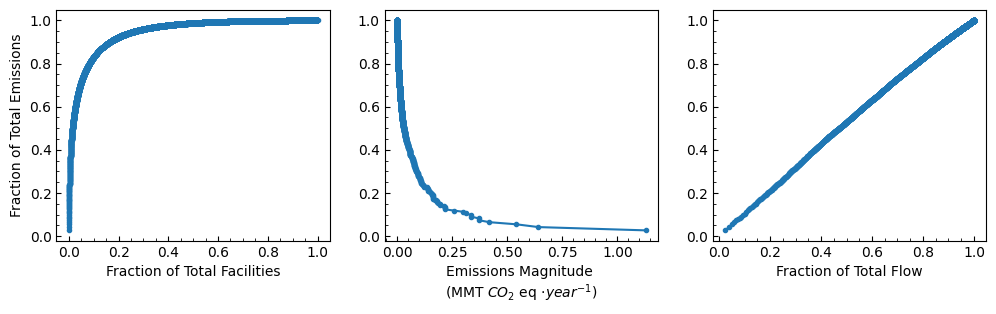

In [37]:
# Make cumulative distribution functions 

# convert kg CO2 / day to MMT / year 

def kg_co2_to_MMT(kgCO2_per_day):
    days_per_year = 365
    MT_per_day = kgCO2_per_day * (1/1000)
    MT_per_year = MT_per_day * days_per_year
    MMT_per_year = MT_per_year * (1/1E6)
    return MMT_per_year

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Create cumulative distribution function for CO2 emissions
# Step 1: Sort the DataFrame by the emissions level
sorted_facilities = facility_data.sort_values(by='total_emission', ascending=False).reset_index(drop=True)
sorted_facilities['MMT_year'] = sorted_facilities['total_emission'].apply(kg_co2_to_MMT)

# Step 2: Calculate the cumulative emissions
sorted_facilities['cumulative_emissions'] = sorted_facilities['total_emission'].cumsum()

# Step 3: Optionally normalize the cumulative emissions to get the CDF
total_emissions = sorted_facilities['total_emission'].sum()
sorted_facilities['cumulative_distribution'] = sorted_facilities['cumulative_emissions'] / total_emissions


# What fraction of facilities contribute to X% of emissions? 
sorted_facilities['facility_rank'] = sorted_facilities.index + 1
sorted_facilities['facility_fraction'] = sorted_facilities['facility_rank'] / len(sorted_facilities)
# display(sorted_facilities)

### Sorting facilities by flow & calculating cumulative flow rate 
# Sort by flow rate 
flow_sorted = facility_data.sort_values(by='FLOW_2022_MGD_FINAL', ascending=False).reset_index(drop=True)

# Calculate the cumulative flow
flow_sorted['cumulative_flow'] = flow_sorted['FLOW_2022_MGD_FINAL'].cumsum()

# calculate total flow & flow fraction
total_flow = flow_sorted['FLOW_2022_MGD_FINAL'].sum()
flow_sorted['flow_fraction'] = flow_sorted['cumulative_flow'] / total_flow

# Cumulative emissions
flow_sorted['cumulative_emissions'] = flow_sorted['total_emission'].cumsum()

# calculate fraction of total emissions
total_emissions = flow_sorted['total_emission'].sum()
flow_sorted['emissions_fraction'] = flow_sorted['cumulative_emissions'] / total_emissions

########### Make plot ###########

# Figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))  # 3 columns 1 row 

# Common settings
marker_size = 3

axs[0].plot(sorted_facilities['facility_fraction'], sorted_facilities['cumulative_distribution'], 
            label='CDF', marker='o', markersize=marker_size)
axs[0].set_xlabel('Fraction of Total Facilities')
axs[0].set_ylabel('Fraction of Total Emissions')
# axs[0].set_title('Cumulative Distribution of Emissions vs Facility Count')
# axs[0].grid(True)

axs[1].plot(sorted_facilities['MMT_year'], sorted_facilities['cumulative_distribution'], 
            label='CDF', marker='o', markersize=marker_size)
axs[1].set_xlabel('Emissions Magnitude \n(MMT $CO_2$ eq $\cdot year^{-1}$)')
# axs[1].grid(True)

axs[2].plot(flow_sorted['flow_fraction'],  flow_sorted['emissions_fraction'], 
            label='CDF', marker='o', markersize=marker_size)
axs[2].set_xlabel('Fraction of Total Flow')
# axs[2].set_ylabel('Fraction of Total Emissions')
# axs[2].grid(True)

# Apply common settings to all subplots
for ax in axs:
    ax.minorticks_on()  # Enable minor ticks
    ax.tick_params(direction='in', which='both')  # Make tick marks face inward
    ax.grid(False)
    #ax.spines['left'].set_position('zero')
    #ax.spines['bottom'].set_position('zero')
    #ax.spines['top'].set_color('none')
    #ax.spines['right'].set_color('none')


In [38]:
# What fraction of facilities account for 80% of emissions? 90%?
display(sorted_facilities.head(10))

top_tt_count = sorted_facilities.head(10)['TT'].value_counts()
print(top_tt_count)

# find index where cumulative emissions first reaches / exceed 80% (0.80) 

def find_facility_fraction(emissions_fraction): 
    index = sorted_facilities[sorted_facilities['cumulative_distribution']>=emissions_fraction].index[0]
    fraction_facilities = sorted_facilities.loc[index, 'facility_fraction']
    print(f'{fraction_facilities*100:.2f}% of facilities account of {emissions_fraction*100:.2f}% of emissions')
    return fraction_facilities
    
find_facility_fraction(0.8)
find_facility_fraction(0.9)

sorted_facilities.head(50).to_csv(pathlib.PurePath('04_results', 'facilities_sorted.csv'))

,Unnamed: 0,CWNS_NUM,FACILITY,STATE,CITY,LATITUDE,LONGITUDE,FLOW_2022_MGD_FINAL,CO2_emission,CH4_emission,...,LA_N2O,total_emission,TT,TT_count,TT_flow_mgd,MMT_year,cumulative_emissions,cumulative_distribution,facility_rank,facility_fraction
0,2301,17000721001,"MWRDGC, Stickney Treatment Plant",IL,Cicero,41.813900,-87.770400,1200.0,95392.377360,1.728623e+06,...,52535.457534,3.092495e+06,[*E1],1,1200.0,1.128761,3.092495e+06,0.026705,1,0.000063
1,6330,26000596001,GLWA WRRF,MI,Detroit,42.283200,-83.128500,686.0,54532.642391,6.398511e+05,...,0.000000,1.757970e+06,"[*B1, *B5]",2,343.0,0.641659,4.850465e+06,0.041885,2,0.000126
2,8821,36002001001,New York (C) - Wards Island WPCP,NY,New York,40.787528,-73.922889,550.0,43721.506290,7.922854e+05,...,8805.078082,1.484673e+06,[F1],1,550.0,0.541906,6.335138e+06,0.054706,3,0.000189
3,3557,17000721009,"MWRDGC, CALUMET WRP, MWRDGC",IL,Chicago,41.662500,-87.610000,450.0,35772.141510,6.482335e+05,...,8473.631507,1.148458e+06,[*E1],1,450.0,0.419187,7.483596e+06,0.064623,4,0.000252
4,6484,11000001001,BLUE PLAINS STP,DC,Washington,38.816781,-77.032755,384.0,30525.560760,5.531592e+05,...,27921.435616,1.020654e+06,[*E1e],1,384.0,0.372539,8.504250e+06,0.073437,5,0.000315
5,15609,48000000409,Austin 5 Year CIP - Citywide Wastewater,TX,Austin,30.274486,-97.740297,285.0,22655.689623,4.105479e+05,...,22722.474113,1.013721e+06,[*E1],1,285.0,0.370008,9.517971e+06,0.082191,6,0.000378
6,14370,55000000052,MILWAUKEE MSD COMBINED - South Shore,WI,South Milwaukee,42.901276,-87.846851,265.0,21065.816667,3.817375e+05,...,21127.914527,9.250474e+05,[*E1e],1,265.0,0.337642,1.044302e+07,0.090179,7,0.000441
7,2763,25000128001,MWRA Deer Island WWTF,MA,Boston,42.350500,-70.956900,315.0,25040.499060,4.537634e+05,...,16021.680822,9.155354e+05,[F1e],1,315.0,0.334170,1.135855e+07,0.098085,8,0.000504
8,10681,36002001011,New York (C) - Newtown Creek WPCP,NY,New York,40.731400,-73.946400,317.0,25199.486350,4.566445e+05,...,4767.189041,8.583370e+05,[*E1],1,317.0,0.313293,1.221689e+07,0.105497,9,0.000567
9,5012,29001023002,Lemay WWTP,MO,Saint Louis,38.532700,-90.270900,350.0,27822.776730,5.041816e+05,...,0.000000,8.247995e+05,[*A1e],1,350.0,0.301052,1.304169e+07,0.112619,10,0.000630


TT
[*E1]         4
[*E1e]        2
[*B1, *B5]    1
[F1]          1
[F1e]         1
[*A1e]        1
Name: count, dtype: int64
8.29% of facilities account of 80.00% of emissions
16.52% of facilities account of 90.00% of emissions


In [39]:
# What fraction of flow is treated by the largest 10 facilities? 

# flow from top 10 facilities
top_ten_facilities = sorted_facilities.head(10)
top_ten_flow = top_ten_facilities['FLOW_2022_MGD_FINAL'].sum()

# flow from all facilities 
# total_flow = sorted_facilities['FLOW_2022_MGD_FINAL'].sum()

print(f'Fraction of flow from top 10 facilities: {top_ten_flow/total_flow*100:.2f}%')

print(f'Total flow: {total_flow}')
print(f"Top 10 facilities flow: {top_ten_flow}")

Fraction of flow from top 10 facilities: 9.86%
Total flow: 48699.762
Top 10 facilities flow: 4802.0


In [40]:
# calculate fractin of flow 
emissions_fraction = 0.8
index = sorted_facilities[sorted_facilities['cumulative_distribution']>=emissions_fraction].index[0]
fraction_facilities = sorted_facilities.loc[index, 'facility_fraction']

included_facilities = sorted_facilities[sorted_facilities['cumulative_distribution'] < emissions_fraction]
display(included_facilities)

included_flow = included_facilities['FLOW_2022_MGD_FINAL'].sum()
fraction_included_flow = included_flow / total_flow
print(f'{fraction_facilities*100:.2f}% of facilities, which treat {fraction_included_flow*100:.2f} of flow,  account of {emissions_fraction*100:.2f}% of emissions')


,Unnamed: 0,CWNS_NUM,FACILITY,STATE,CITY,LATITUDE,LONGITUDE,FLOW_2022_MGD_FINAL,CO2_emission,CH4_emission,...,LA_N2O,total_emission,TT,TT_count,TT_flow_mgd,MMT_year,cumulative_emissions,cumulative_distribution,facility_rank,facility_fraction
0,2301,17000721001,"MWRDGC, Stickney Treatment Plant",IL,Cicero,41.813900,-87.770400,1200.00,95392.377360,1.728623e+06,...,52535.457534,3.092495e+06,[*E1],1,1200.00,1.128761,3.092495e+06,0.026705,1,0.000063
1,6330,26000596001,GLWA WRRF,MI,Detroit,42.283200,-83.128500,686.00,54532.642391,6.398511e+05,...,0.000000,1.757970e+06,"[*B1, *B5]",2,343.00,0.641659,4.850465e+06,0.041885,2,0.000126
2,8821,36002001001,New York (C) - Wards Island WPCP,NY,New York,40.787528,-73.922889,550.00,43721.506290,7.922854e+05,...,8805.078082,1.484673e+06,[F1],1,550.00,0.541906,6.335138e+06,0.054706,3,0.000189
3,3557,17000721009,"MWRDGC, CALUMET WRP, MWRDGC",IL,Chicago,41.662500,-87.610000,450.00,35772.141510,6.482335e+05,...,8473.631507,1.148458e+06,[*E1],1,450.00,0.419187,7.483596e+06,0.064623,4,0.000252
4,6484,11000001001,BLUE PLAINS STP,DC,Washington,38.816781,-77.032755,384.00,30525.560760,5.531592e+05,...,27921.435616,1.020654e+06,[*E1e],1,384.00,0.372539,8.504250e+06,0.073437,5,0.000315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,6664,37005501001,LINCOLNTON WWTP,NC,Lincolnton,35.451000,-81.260600,6.00,476.961887,8.643113e+03,...,344.375342,1.429915e+04,[*C1],1,6.00,0.005219,9.257932e+07,0.799453,1311,0.082624
1311,7121,6005205001,"Davis, City of WWTP",CA,Davis,38.590600,-121.670800,7.50,596.202359,1.080389e+04,...,204.803425,1.429892e+04,[*A1e],1,7.50,0.005219,9.259362e+07,0.799576,1312,0.082687
1312,14779,12000287005,Sandhill WWTP,FL,Kissimmee,28.309400,-81.607200,6.00,476.961887,8.643113e+03,...,405.493151,1.428857e+04,[*C1],1,6.00,0.005215,9.260790e+07,0.799700,1313,0.082750
1313,55,48000005001,Victoria Regional WWTP,TX,Victoria,28.755200,-97.000900,9.60,763.139019,4.079387e+03,...,759.476918,1.428247e+04,[A3],1,9.60,0.005213,9.262219e+07,0.799823,1314,0.082813


8.29% of facilities, which treat 76.24 of flow,  account of 80.00% of emissions


Relevant text from paper (9/28): 

"We find that across the United States, 8% of facilities account for 80% of emissions (Figure 5A), with a strong linear relationship between total emissions and total flow (Figure 5B). In fact, the largest 10 facilities in the country (0.06% of facilities) disproportionately account for 11% of total emissions (Figure 5C). Within these facilities, all but one treat their solids with anaerobic digestion (solids code 1); the exception uses multiple hearth incineration (solids code 5). Six of these plants use nitrification (liquids code *E), two are fully denitrifying facilities (liquids code F), one uses conventional activated sludge (liquids code A), and one uses pure oxygen activated sludge (liquids code B). Notably, we find four of the largest ten facilities in the United States reports onsite energy recovery with CHP." 

## Discussion section 

In [41]:
print(f'Lowest emissions from a treatment train: {tt_data["total_emissions_national_kgCO2_per_m3"].min():0.4f}')
print(f'Highest emissions from a treatment train: {tt_data["total_emissions_national_kgCO2_per_m3"].max():0.4f}')


Lowest emissions from a treatment train: 0.3405
Highest emissions from a treatment train: 1.6057


In [42]:
# What fraction of emissions comes from facilities with AD? 

total_methane = solids_sorted_by_emissions['methane_mmtCO2_per_year'].sum() + solids_sorted_by_emissions['landfill_methane_mmtCO2_per_year'].sum()

solids_sorted_by_emissions['total_methane'] = (solids_sorted_by_emissions['methane_mmtCO2_per_year'] + solids_sorted_by_emissions['landfill_methane_mmtCO2_per_year'])

solids_sorted_by_emissions['methane_fraction'] = (solids_sorted_by_emissions['methane_mmtCO2_per_year'] + solids_sorted_by_emissions['landfill_methane_mmtCO2_per_year'])/ (total_methane) * 100 

methane_ad_columns = ['tt_solids', 'methane_fraction', 'total_methane']
display(solids_sorted_by_emissions[methane_ad_columns])

,tt_solids,methane_fraction,total_methane
0,1,85.602432,16.962692
2,3,7.240290,1.434712
6,L-all,2.895377,0.573738
4,5,2.215612,0.439038
5,6,1.082902,0.214584
3,4,0.919088,0.182123
1,2,0.044299,0.008778


In [43]:
# Repeat analysis above, comparing emissions from facilities with and without CHP 

# Get the pairs using the first function
pairs = find_chp_pairs(tt_ad)

# Compare electricity values for each pair using the new function
comparison_results = compare_emissions_for_pairs(tt_ad, pairs)

comparison_df = pd.DataFrame(comparison_results, columns=[
        'Code 1', 'Code 2', 'Total Emissions 1 (kg CO2/m3)', 'Total Emissions 2 (kg CO2/m3)', 'Absolute Diff', '% Diff'])

display(comparison_df)

print(f"Minimum energy savings from CHP: {comparison_df['Absolute Diff'].min()}")
print(f"Maximum energy savings from CHP: {comparison_df['Absolute Diff'].max()}")


,Code 1,Code 2,Total Emissions 1 (kg CO2/m3),Total Emissions 2 (kg CO2/m3),Absolute Diff,% Diff
0,*A1,*A1e,0.624,0.562,-0.061,-9.799
1,*B1,*B1e,0.637,0.578,-0.059,-9.195
2,*C1,*C1e,0.599,0.547,-0.052,-8.655
3,*E1,*E1e,0.836,0.778,-0.058,-6.906
4,*G1,*G1e,1.001,0.949,-0.051,-5.139
5,*G1-p,*G1e-p,0.889,0.831,-0.058,-6.503
6,A1,A1e,0.629,0.576,-0.052,-8.334
7,F1,F1e,0.851,0.810,-0.041,-4.841


Minimum energy savings from CHP: -0.061
Maximum energy savings from CHP: -0.041


In [44]:
# Compare anaerobic digestion to aerobic digestion 

tt_aerobic_vs_anaerobic = tt_data 
methane_cols = ['code', 'methane_kgCO2_per_m3']
display(tt_aerobic_vs_anaerobic.loc[tt_aerobic_vs_anaerobic['code'].isin(['A1', 'A3', '*A1', '*A3', '*B1', '*B3'])][methane_cols])

print(f'Difference between anaerobic and aerobic digestion: {0.380546 - 0.112257:4f}')

,code,methane_kgCO2_per_m3
13,*A3,0.112257
14,*B3,0.112257
15,A3,0.112257
34,*A1,0.380546
35,*B1,0.380546
37,A1,0.380546


Difference between anaerobic and aerobic digestion: 0.268289


In [45]:
# EPA inventory breakdown 

epa_methane_treatment = 11.6 # MMT / year in 2022
epa_methane_effluent = 2.0 # MMT / year in 2022
epa_n2o_treatment = 17.0 # MMT / year in 2022 
epa_n2o_effluent = 4.4 

epa_total_onsite = epa_methane_effluent + epa_methane_treatment + epa_n2o_effluent + epa_n2o_treatment
epa_treatment_only = epa_methane_treatment + epa_n2o_treatment

print(f'EPA emissions total (MMT / year): {epa_total_onsite}')
print(f'EPA emissions onsite only (MMT / year): {epa_treatment_only}')

print(f'EPA fraction of onsite emissions from methane: {epa_methane_treatment/epa_treatment_only *100:0.2f}%')
print(f'EPA fraction of onsite emissions from nitrous oxide: {epa_n2o_treatment/epa_treatment_only *100:0.2f}%')

our_methane = national_breakdown_df.loc['methane']['CO2_MMT_per_year'] # MMT / year
our_nitrous_oxide = national_breakdown_df.loc['nitrous_oxide']['CO2_MMT_per_year']# MMT / year
our_total_onsite = our_methane + our_nitrous_oxide
print(f'In our inventory, onsite emissions from methane and nitrous oxide are: {our_total_onsite:.2f}')
print(f'In our inventory, methane fraction of onsite emissions: {our_methane/(our_methane+our_nitrous_oxide)*100:.2f}%')

print(f'In our inventory, methane fraction of onsite emissions: {our_nitrous_oxide/(our_methane+our_nitrous_oxide)*100:.2f}%')

EPA emissions total (MMT / year): 35.0
EPA emissions onsite only (MMT / year): 28.6
EPA fraction of onsite emissions from methane: 40.56%
EPA fraction of onsite emissions from nitrous oxide: 59.44%
In our inventory, onsite emissions from methane and nitrous oxide are: 27.59
In our inventory, methane fraction of onsite emissions: 68.72%
In our inventory, methane fraction of onsite emissions: 31.28%


In [46]:
display(national_breakdown_df)

,CO2_kg_per_day,CO2_MMT_per_year,emissions_percent
CO2,3.871322e+06,1.413032,3.343014
methane,5.193888e+07,18.957692,44.850938
nitrous_oxide,2.364478e+07,8.630344,20.418047
electricity,2.928826e+07,10.690213,25.291374
onsite_gas,2.825041e+06,1.031140,2.439516
upstream_gas,6.372650e+05,0.232602,0.550299
landfill_methane,1.319422e+06,0.481589,1.139364
land_application_N2O,2.278369e+06,0.831605,1.967447
total,1.158033e+08,42.268217,100.000000


In [47]:
# Discussion of maps 
facilities_e1 = filter_facilities_by_process('*E1', facility_data, print_tt=True)

total_emissions = facility_data['total_emission'].apply(kg_per_day_to_mmt_per_year).sum()

def facility_key_stats(processes, df, match_all=False, print_tt=False, match_type='substring'): 
    
    facility_filtered = filter_facilities_by_process(processes, df, match_all=match_all, print_tt=print_tt, match_type=match_type)
    
    facility_num = len(facility_filtered)
    facility_emissions = facility_filtered['total_emission'].apply(kg_per_day_to_mmt_per_year).sum()
    
    print(f"Total number of facilities matching the criteria: {facility_num}")
    print(f"\nTotal emissions from these facilities (in MMT CO2eq/day): {facility_emissions}")
    print(f"\nFraction of total emissions (in MMT CO2eq/day): {facility_emissions/total_emissions*100:.4f}%")


 
flow_value = tt_data.loc[tt_data['code'] == '*E1', 'flow_Bm3yr'].values[0]
print(f'Flow for facilitie'
      f's with *E1: {flow_value}')
facility_key_stats('*E1', facilities_e1, print_tt=True)

Flow for facilities with *E1: 9.63806922036905
Total number of facilities matching the criteria: 613

Total emissions from these facilities (in MMT CO2eq/day): 11.499402838375113

Fraction of total emissions (in MMT CO2eq/day): 27.2058%


In [48]:
facilities_a1 = filter_facilities_by_process('*A1', facility_data, print_tt=True, match_type='exact')
flow_value_a1 = tt_data.loc[tt_data['code'] == '*A1', 'flow_Bm3yr'].values[0]
print(f'Flow for facilities with *A1: {flow_value_a1}')
facility_key_stats('*A1', facilities_a1, print_tt=True)

Flow for facilities with *A1: 6.499311635348686
Total number of facilities matching the criteria: 777

Total emissions from these facilities (in MMT CO2eq/day): 4.540785899346057

Fraction of total emissions (in MMT CO2eq/day): 10.7428%


In [50]:
# Discussion section - where do trickling filters fall in terms of total emissions? 

tt_total_emissions_sorted_low_to_high = tt_total_emissions.sort_values(by='total_emissions_national_kgCO2_per_m3', ascending=True)
display(tt_total_emissions_sorted_low_to_high[total_emissions_columns])

,code,total_emissions_national_kgCO2_per_m3,fraction_scope1,fraction_energy,fraction_biosolids,fraction_methane,fraction_nitrous_oxide,fraction_noncombustion_co2
1,*C6,0.340500,53.133531,46.866469,0.000000,32.968205,13.997898,6.167428
0,*C4,0.358070,64.619084,35.380916,14.092840,31.350441,13.311014,5.864789
4,*A6,0.367451,49.236291,50.763709,0.000000,30.550052,12.971179,5.715059
6,*C3,0.369165,58.781247,41.218753,9.773541,30.408221,12.910959,5.688526
7,*B6,0.378466,47.803418,52.196582,0.000000,29.660986,12.593693,5.548740
3,*A4,0.385131,60.078777,39.921223,13.102640,29.147676,12.375747,5.452714
9,A4,0.385723,53.405521,46.594479,6.501551,29.102898,12.356735,5.444337
10,A6,0.389957,46.394723,53.605277,0.000000,28.786921,12.222575,5.385227
5,*B4,0.396036,58.424389,41.575611,12.741833,28.345037,12.034957,5.302562
15,A3,0.400222,49.684966,50.315034,4.480202,28.048577,11.909083,5.247103


In [49]:
display_cols = ['tt_solids','flow_Bm3yr', 'total_emissions_annual_mmtCO2_per_year', 'emissions_fraction']
display(solids_sorted_by_count[display_cols])

,tt_solids,flow_Bm3yr,total_emissions_annual_mmtCO2_per_year,emissions_fraction
6,L-all,5.601269,2.731338,6.429300
2,3,11.612792,5.413121,12.741953
0,1,42.856272,30.908242,72.754951
4,5,3.911037,1.958925,4.611117
3,4,1.372237,0.579673,1.364492
5,6,1.911558,0.876099,2.062251
1,2,0.022107,0.015266,0.035936
